In [ ]:
!pip install corner

### Mother Likelihood Equation

Posterior ∝ Prior * Likelihood

Posterior ∝ P(Θ) * Likelihood

Now Likelihood =

$$
\text{Li} = \iiint d\mathcal{M}_z \, dD_L \, d\tilde{\Lambda} \;
P(D_{L,obs}, \mathcal{M}_{z,obs}, \tilde{\Lambda}_{obs} \mid D_L, \mathcal{M}_z, \tilde{\Lambda})
$$

$$
\quad \cdot \delta\left( \tilde{\Lambda} - \hat{\tilde{\Lambda}}\left( \frac{\mathcal{M}_z}{1 + z(D_L, \text{Cos})}, \text{EoS} \right) \right)
$$

$$
\quad \cdot f(D_L) \cdot \frac{1}{1 + z(D_L, \text{Cos})} \cdot
\mathcal{N}\left( \frac{\mathcal{M}_z}{1 + z(D_L, \text{Cos})} \mid \text{Pop} \right)
$$

### ADDING NOISE TO THE DATA OF LUMINOSITY DISTANCE

Now adding the noise to DL (later try adding mass ratio and then add correlation, the problem is computation speed)

Likelihood with noise in luminosity distance

For each event \(i\), the likelihood is

$$
\mathcal L_i
= \int_0^\infty dz\;
\underbrace{\mathcal N\!\big(D_{L,\text{obs},i}\mid D_L(z;\text{Cos}),\,\sigma_{D_L,i}\big)}_{\text{distance measurement}}
\cdot
\underbrace{\mathcal N\!\left(\tilde{\Lambda}^{\text{obs}}_i \,\middle|\,
\hat{\tilde{\Lambda}}\!\left(\tfrac{\mathcal M_{z,\text{obs},i}}{1+z},\text{EoS}\right),
\sigma_{\tilde{\Lambda},i}\right)}_{\text{tidal measurement}}
\cdot
\underbrace{\frac{1}{1+z}}_{\text{redshift Jacobian}}
\cdot
\underbrace{P(z)}_{\text{cosmological/redshift prior}}
\cdot
\underbrace{\mathcal N\!\left(\tfrac{\mathcal M_{z,\text{obs},i}}{1+z}\,\middle|\,\mu_p,\sigma_p\right)}_{\text{population prior on source-frame mass}}.
$$

The full likelihood is the product over all events:

$$
\mathcal L = \prod_{i=1}^N \mathcal L_i.
$$

In log form (often used in inference):

$$
\log \mathcal L = \sum_{i=1}^N \log \mathcal L_i.
$$

Now changing the likelihood to simplify the integral over z,

Note :
$P(z) \sim \beta(3,9)$, drawing $z_{ik}$ samples, we get:

$$
L_i = \prod_i \sum_{z_{ik}} \left(\frac{1}{1+z_{ik}}\right) \cdot \mathcal{N}(D_{Lobs} | D_L, C) \cdot \mathcal{N}(\tilde{\Lambda}_{obs} | \tilde{\Lambda}, E) \cdot \mathcal{N}\left(\frac{M_{zobs}}{1+z_{ik}} \Big| \mu_p, \sigma_p\right)
$$


To note : For Nobs = 100 , sampling = 2000+6000or 4000+4000

Changing the formula for Lambda tilde,

$$
\tilde{\Lambda} = c_0 + c_1 (M_c - \mu_p)
$$

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
H0       0.767  0.115   0.575    0.990      0.020    0.007      31.0   
Om       0.256  0.061   0.147    0.365      0.012    0.002      28.0   
w       -1.263  0.322  -1.903   -0.695      0.030    0.006     117.0   
mu_p     1.170  0.025   1.125    1.216      0.005    0.001      26.0   
sigma_p  0.103  0.008   0.089    0.118      0.000    0.000    1148.0   
c0       4.765  0.052   4.668    4.862      0.001    0.001    2744.0   
c1      -4.951  0.121  -5.183   -4.735      0.020    0.006      33.0   

         ess_tail  r_hat  
H0          248.0   1.06  
Om          253.0   1.07  
w          1021.0   1.03  
mu_p        212.0   1.07  
sigma_p    4307.0   1.01  
c0         3980.0   1.00  
c1          271.0   1.06  


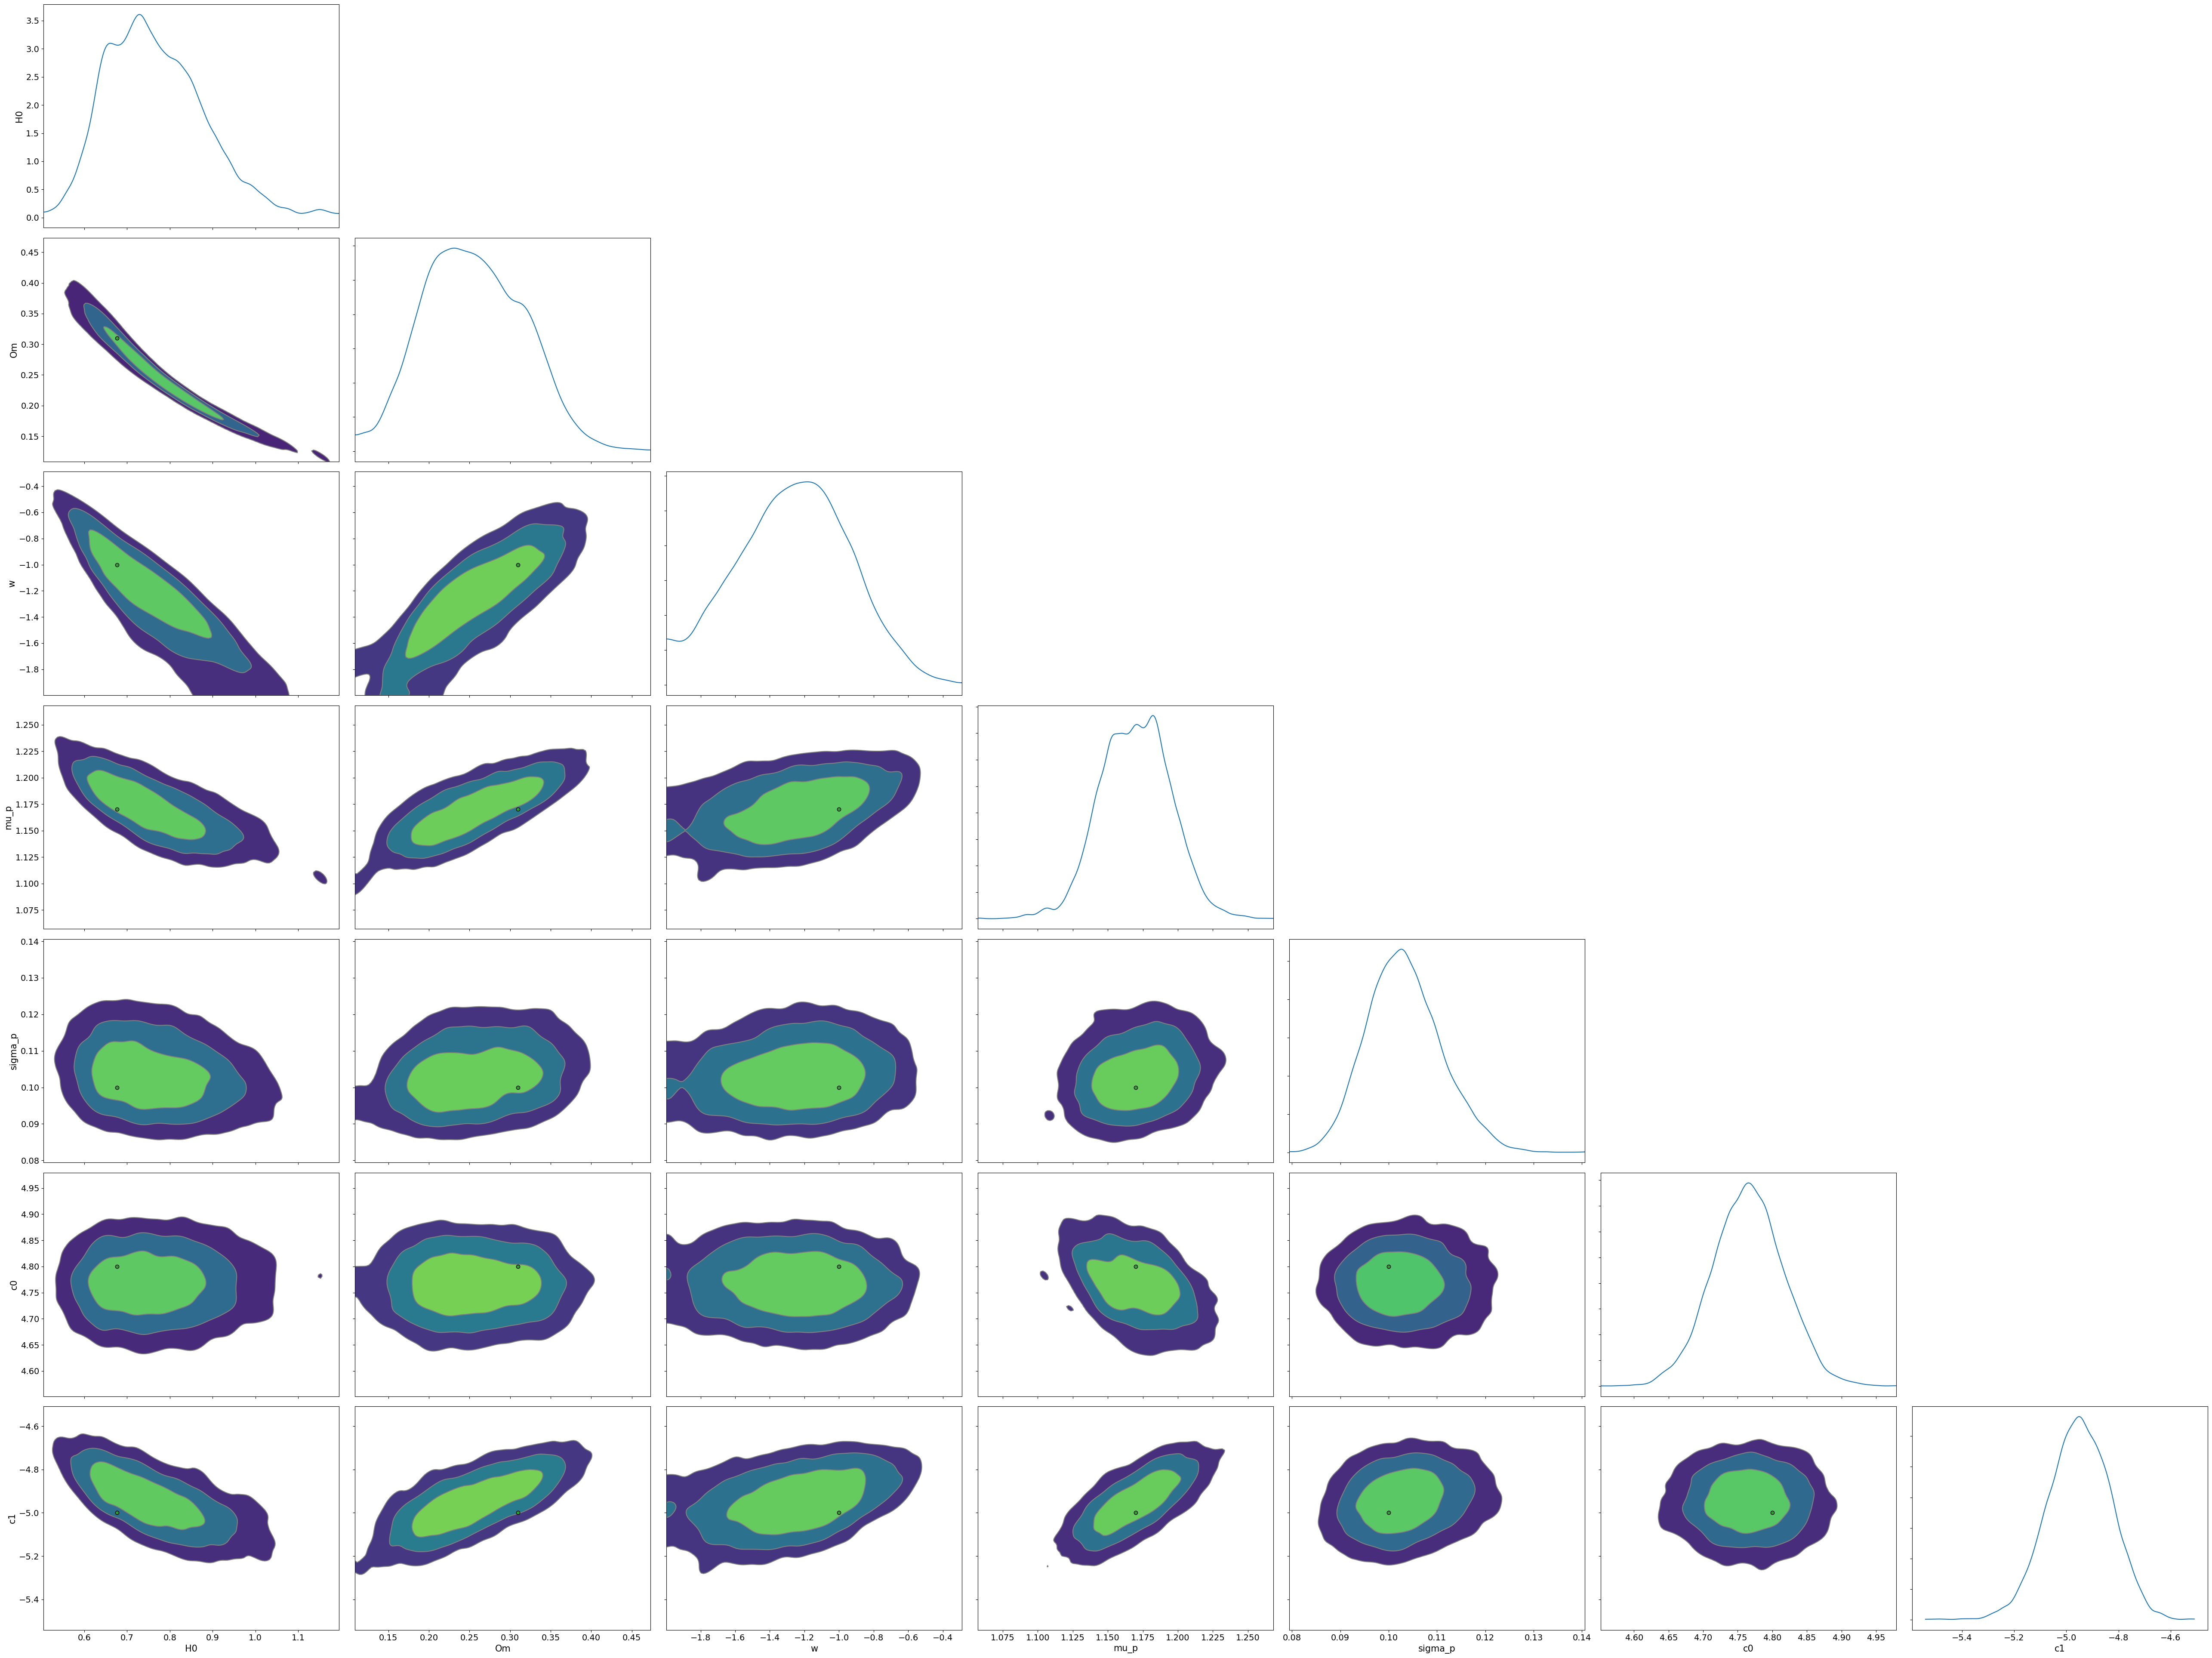

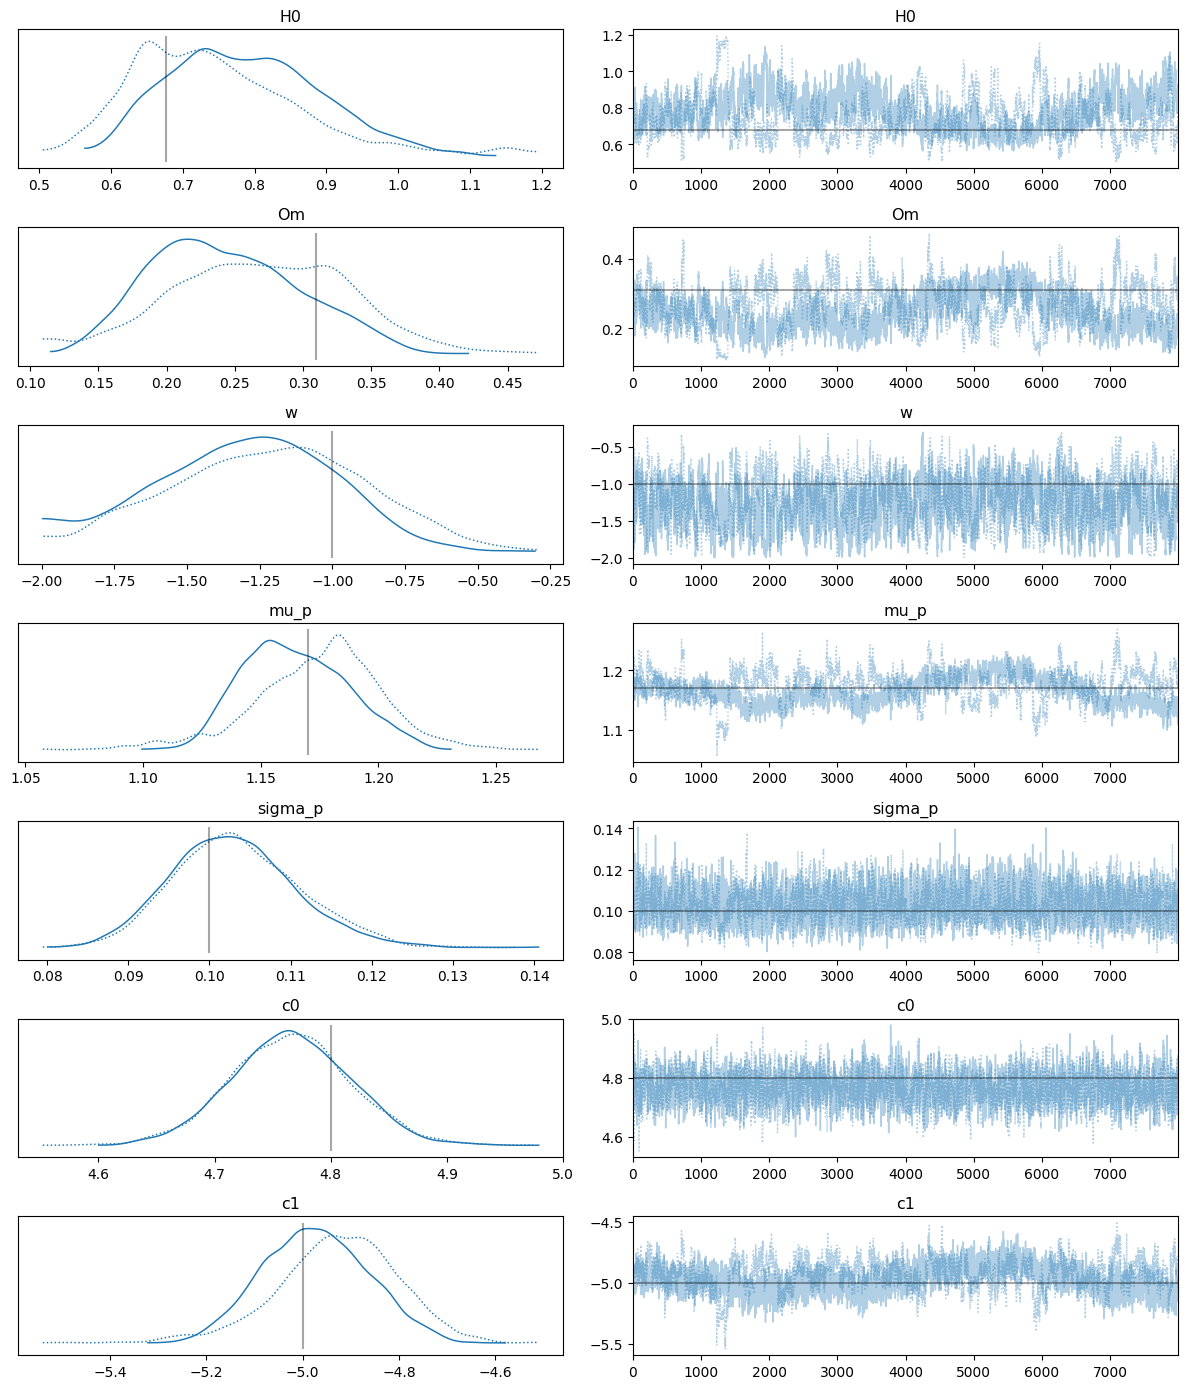

In [ ]:
import pymc as pm
import pytensor.tensor as pt
import pytensor.tensor.extra_ops as pte
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u

# --- Functions ---
def Ez(z, Om, w, wDM):
    opz = 1 + z
    return pt.sqrt(Om * opz ** (3 * (1 + wDM)) + (1 - Om) * opz ** (3 * (1 + w)))

def dCs(zs, Om, w, wDM):
    dz = zs[1:] - zs[:-1]
    fz = 1 / Ez(zs, Om, w, wDM)
    I = 0.5 * dz * (fz[:-1] + fz[1:])
    return pt.concatenate([pt.as_tensor([0.0]), pt.cumsum(I)])

def dLs(zs, dCs):
    return dCs * (1 + zs)

def pt_interp(x, xs, ys):
    x = pt.as_tensor(x)
    xs = pt.as_tensor(xs)
    ys = pt.as_tensor(ys)
    ind = pte.searchsorted(xs, x)
    ind = pt.clip(ind, 1, xs.shape[0] - 1)
    r = (x - xs[ind - 1]) / (xs[ind] - xs[ind - 1])
    return r * ys[ind] + (1 - r) * ys[ind - 1]

# --- Mock data ---
Nobs = 100  # Increased data points
z_true = np.random.beta(3, 9, Nobs) * 10
DL_true = cosmo.luminosity_distance(z_true).to(u.Gpc).value
sigma_DL = 0.07
DL_obs = np.random.normal(DL_true, sigma_DL)
mu_p_true = 1.17
sigma_p_true = 0.1
M_source_true = np.random.normal(mu_p_true, sigma_p_true, size=Nobs)
Mz_true = (1 + z_true) * M_source_true
c0_true = 4.8
c1_true = -5.0
Lambda_true = c0_true + c1_true * ((M_source_true - mu_p_true) / 1.0)
sigma_lambda = 0.07
Lambda_obs = np.random.normal(Lambda_true, sigma_lambda)
Mz_obs = Mz_true

zinterp = np.linspace(0, 10, 1000)

# --- Model ---
with pm.Model() as model:

    # Priors for cosmology
    H0 = pm.Uniform("H0", 0.5, 1.20)
    Om = pm.Uniform("Om", 0.1, 0.5)
    w = pm.Uniform("w", -2.0, -0.01)
    wDM = 0.0

    # Priors for mass distribution
    mu_p = pm.Uniform("mu_p", 0.5, 2.0)
    sigma_p = pm.Uniform("sigma_p", 0.0, 0.5)

    # Priors for Lambda relation
    c0 = pm.Uniform("c0", 3.0, 6.0)
    c1 = pm.Uniform("c1", -7.0, -3.0)

    # Latent redshifts
    z_unit = pm.Beta("z_unit", 3, 9, shape=Nobs)
    z = pm.Deterministic("z", z_unit * 10)

    # Cosmological distances
    dH = pm.Deterministic("dH", 2.99792 / H0)  # Gpc
    dCinterp = dH * dCs(zinterp, Om, w, wDM)
    dLinterp = dLs(zinterp, dCinterp)
    dL = pm.Deterministic("dL", pt_interp(z, zinterp, dLinterp))

    # Masses in source frame
    Mc = pm.Deterministic("Mc", Mz_obs / (1 + z))

    # --- Reparameterized Lambda_til ---
    Lambda_til = c0 + c1 * (Mc - mu_p)

    # --- Likelihoods ---
    pm.Potential("mcprior", pt.sum(pm.logp(pm.Normal.dist(mu_p, sigma_p), Mc)))
    pm.Potential("mcjac", pt.sum(-pt.log1p(z)))  # Jacobian for transformation
    pm.Normal("dL_likelihood", mu=dL, sigma=sigma_DL, observed=DL_obs)
    pm.Normal("Lambda_til_likelihood", mu=Lambda_til, sigma=sigma_lambda, observed=Lambda_obs)

    # Initial values
    initvals = {
        "H0": cosmo.H0.value / 100,
        "Om": cosmo.Om0,
        "w": -1.0,
        "mu_p": 1.17,
        "sigma_p": 0.1,
        "c0": 4.8,
        "c1": -5.0,
    }

    # Sampling
    trace = pm.sample(8000, tune=2000, target_accept=0.95, initvals=initvals, max_treedepth = 15)

# --- Plotting ---
true_vals = {
    "H0": cosmo.H0.value / 100,
    "Om": cosmo.Om0,
    "w": -1.0,
    "mu_p": 1.17,
    "sigma_p": 0.1,
    "c0": 4.8,
    "c1": -5.0,
}

summary = az.summary(trace, var_names=["H0", "Om", "w", "mu_p", "sigma_p", "c0", "c1"])
print(summary)
az.plot_pair(
    trace,
    var_names=["H0", "Om", "w", "mu_p", "sigma_p", "c0", "c1"],
    kind="kde",
    marginals=True,
    reference_values=true_vals,
)
plt.tight_layout()
plt.show()

az.plot_trace(trace, var_names=["H0","Om","w", "mu_p", "sigma_p", "c0","c1"],
                 lines=[('H0', {}, cosmo.H0.value/100),
                        ('Om', {}, cosmo.Om0),
                        ('w', {}, -1),
                        ('mu_p', {}, 1.17),
                        ('sigma_p', {}, 0.1),
                        ('c0', {}, 4.8),
                        ('c1', {}, -5.0),])
plt.tight_layout()
plt.show()


In [ ]:
# Save the trace to the Colab environment
az.to_netcdf(trace, "Nobs100_0709_inference_data_8k2k_95ta.nc")
print("Trace saved to Colab session storage: Nobs100_0709_inference_data_8k2k_95ta.nc")

Trace saved to Colab session storage: Nobs100_0709_inference_data_8k2k_95ta.nc


In [ ]:
from google.colab import files

files.download("Nobs100_0709_inference_data_8k2k_95ta.nc")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


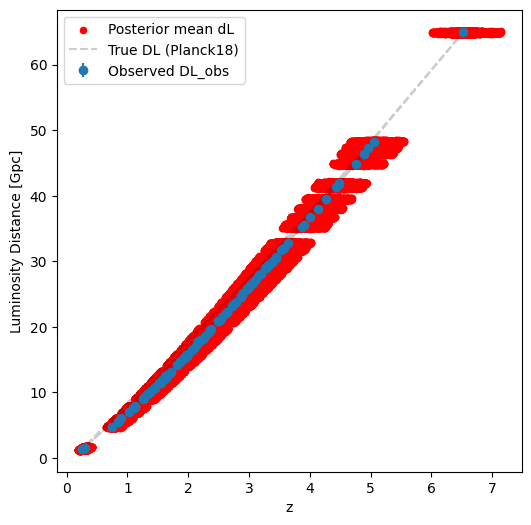

In [ ]:
import matplotlib.pyplot as plt

# take posterior mean of dL for comparison
dL_mean = trace.posterior["dL"].values
z_mean = trace.posterior["z"].values

plt.figure(figsize=(6,6))
plt.errorbar(z_true, DL_obs, yerr=0.07, fmt='o', label="Observed DL_obs")
plt.scatter(z_mean, dL_mean, color="r", label="Posterior mean dL", s=20)
plt.plot(z_true, DL_true, "k--", label="True DL (Planck18)", alpha=0.2)
plt.xlabel("z")
plt.ylabel("Luminosity Distance [Gpc]")
plt.legend()
plt.show()


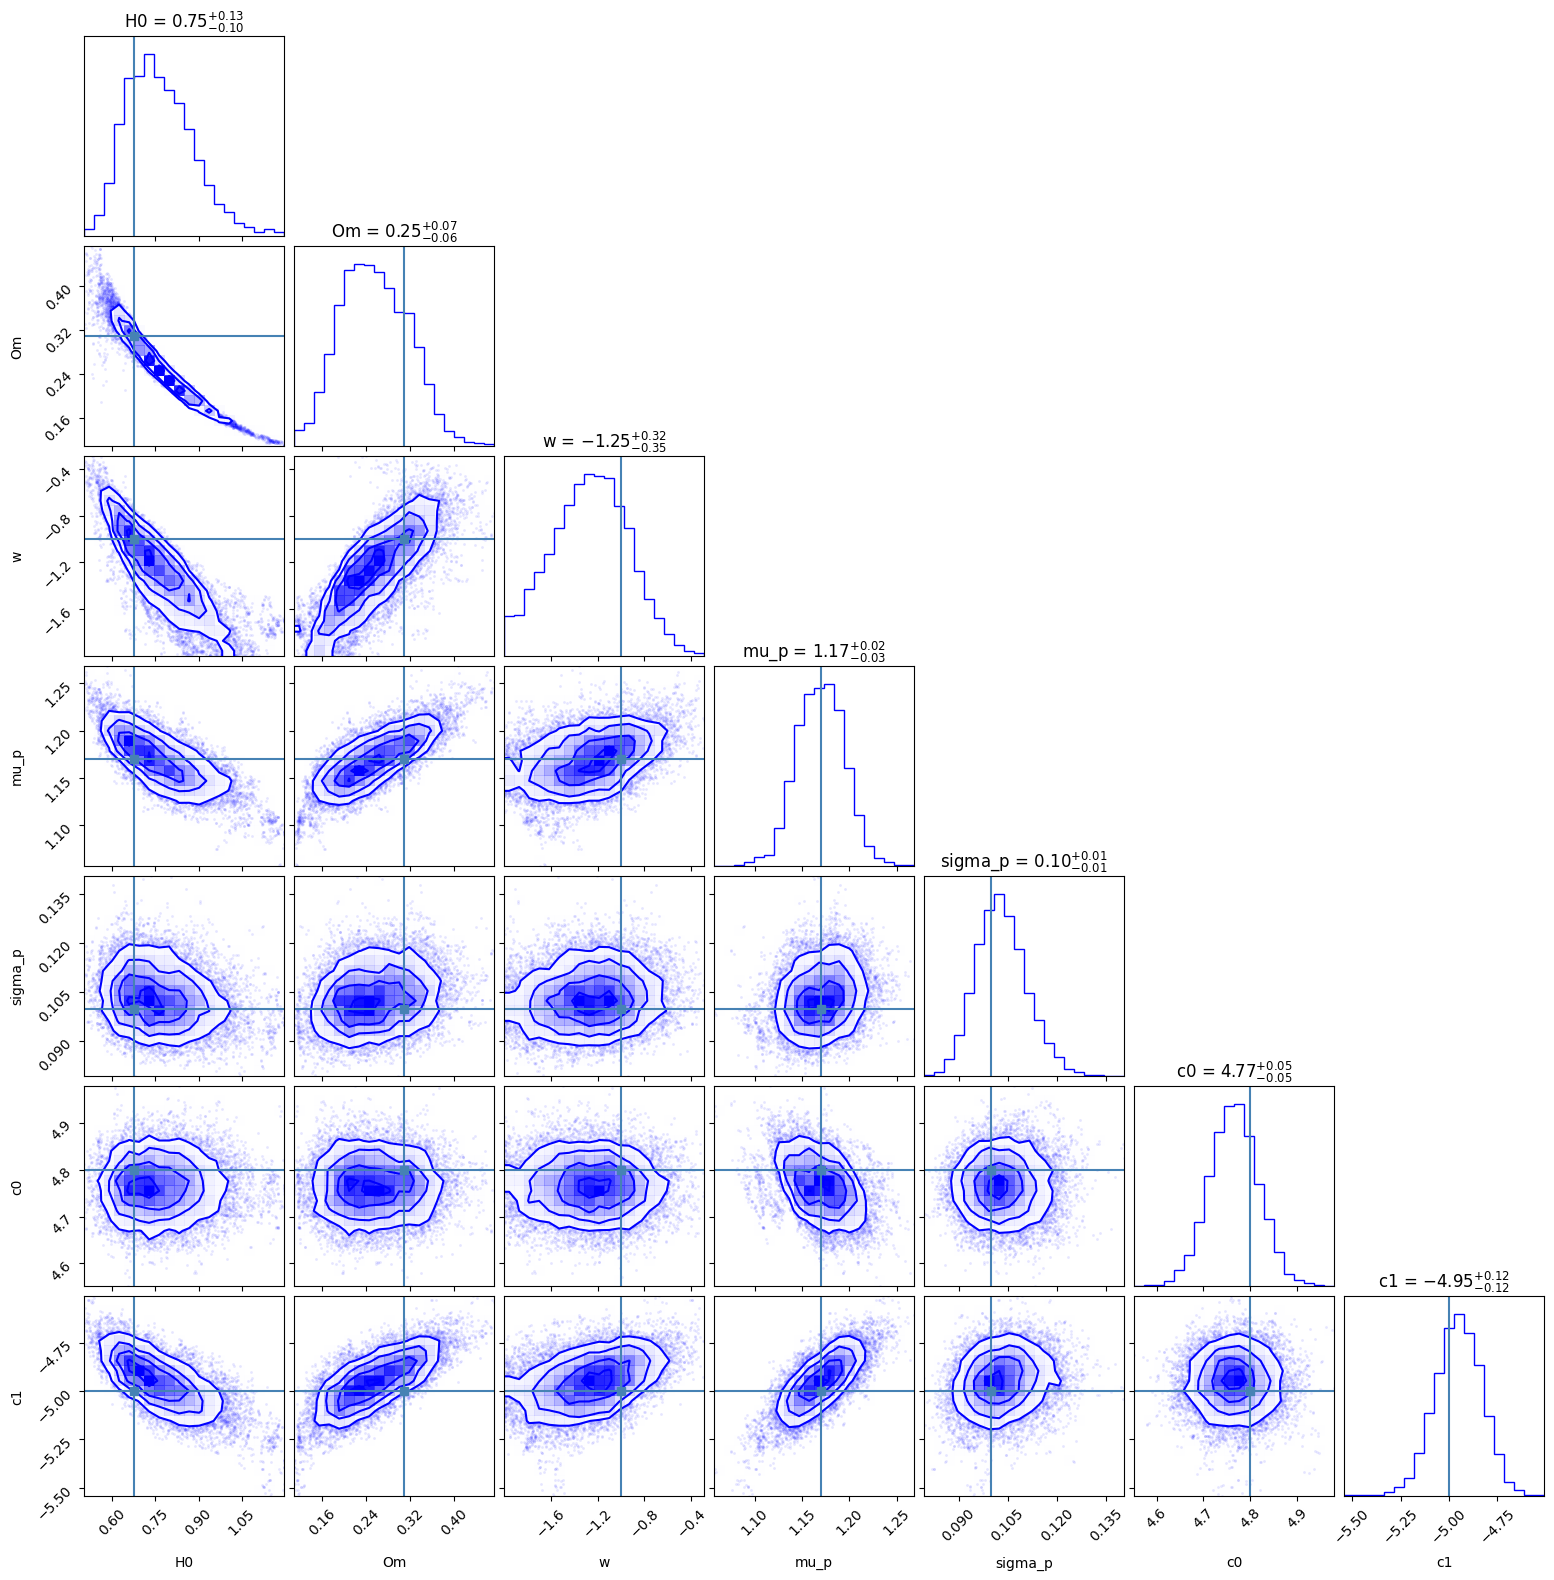

In [ ]:
import corner

# Extract the relevant parameters from the traces
trace_data = trace.posterior.stack(samples=("chain", "draw"))[["H0", "Om", "w", "mu_p", "sigma_p", "c0", "c1"]].to_array().values.T

# Define the labels and true values for the parameters
labels = ["H0", "Om", "w", "mu_p", "sigma_p", "c0", "c1"]
true_values = [cosmo.H0.value/100, cosmo.Om0, -1.0, 1.17, 0.1, 4.8, -5.0]

# Create the corner plot
figure = corner.corner(trace_data, labels=labels, show_titles=True, color="blue", hist_kwargs={"density": True}, truths=true_values)

plt.show()

Now,

I am sampling Hz from minimum value of Hz/z plot. Then using the Hz deterministically sample H0 and use them for the sample. This might help in the sampliung speed ( as it avoids the banana structure formation which gets converted to circle )

Using optimal z_pivot = 0.6811962036943254


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
H_pivot  0.983  0.034   0.923    1.048      0.006    0.003      29.0   
H0       0.651  0.079   0.507    0.808      0.014    0.004      31.0   
Om       0.327  0.060   0.218    0.440      0.010    0.004      37.0   
w       -0.942  0.313  -1.624   -0.388      0.021    0.013     209.0   
mu_p     1.180  0.026   1.132    1.230      0.005    0.002      25.0   
sigma_p  0.110  0.008   0.095    0.125      0.000    0.000     554.0   
c0       4.815  0.054   4.717    4.923      0.001    0.001    1502.0   
c1      -4.976  0.122  -5.196   -4.742      0.023    0.008      27.0   

         ess_tail  r_hat  
H_pivot      69.0   1.03  
H0          101.0   1.02  
Om          186.0   1.02  
w           201.0   1.00  
mu_p         84.0   1.03  
sigma_p    2488.0   1.00  
c0         2102.0   1.00  
c1           91.0   1.02  


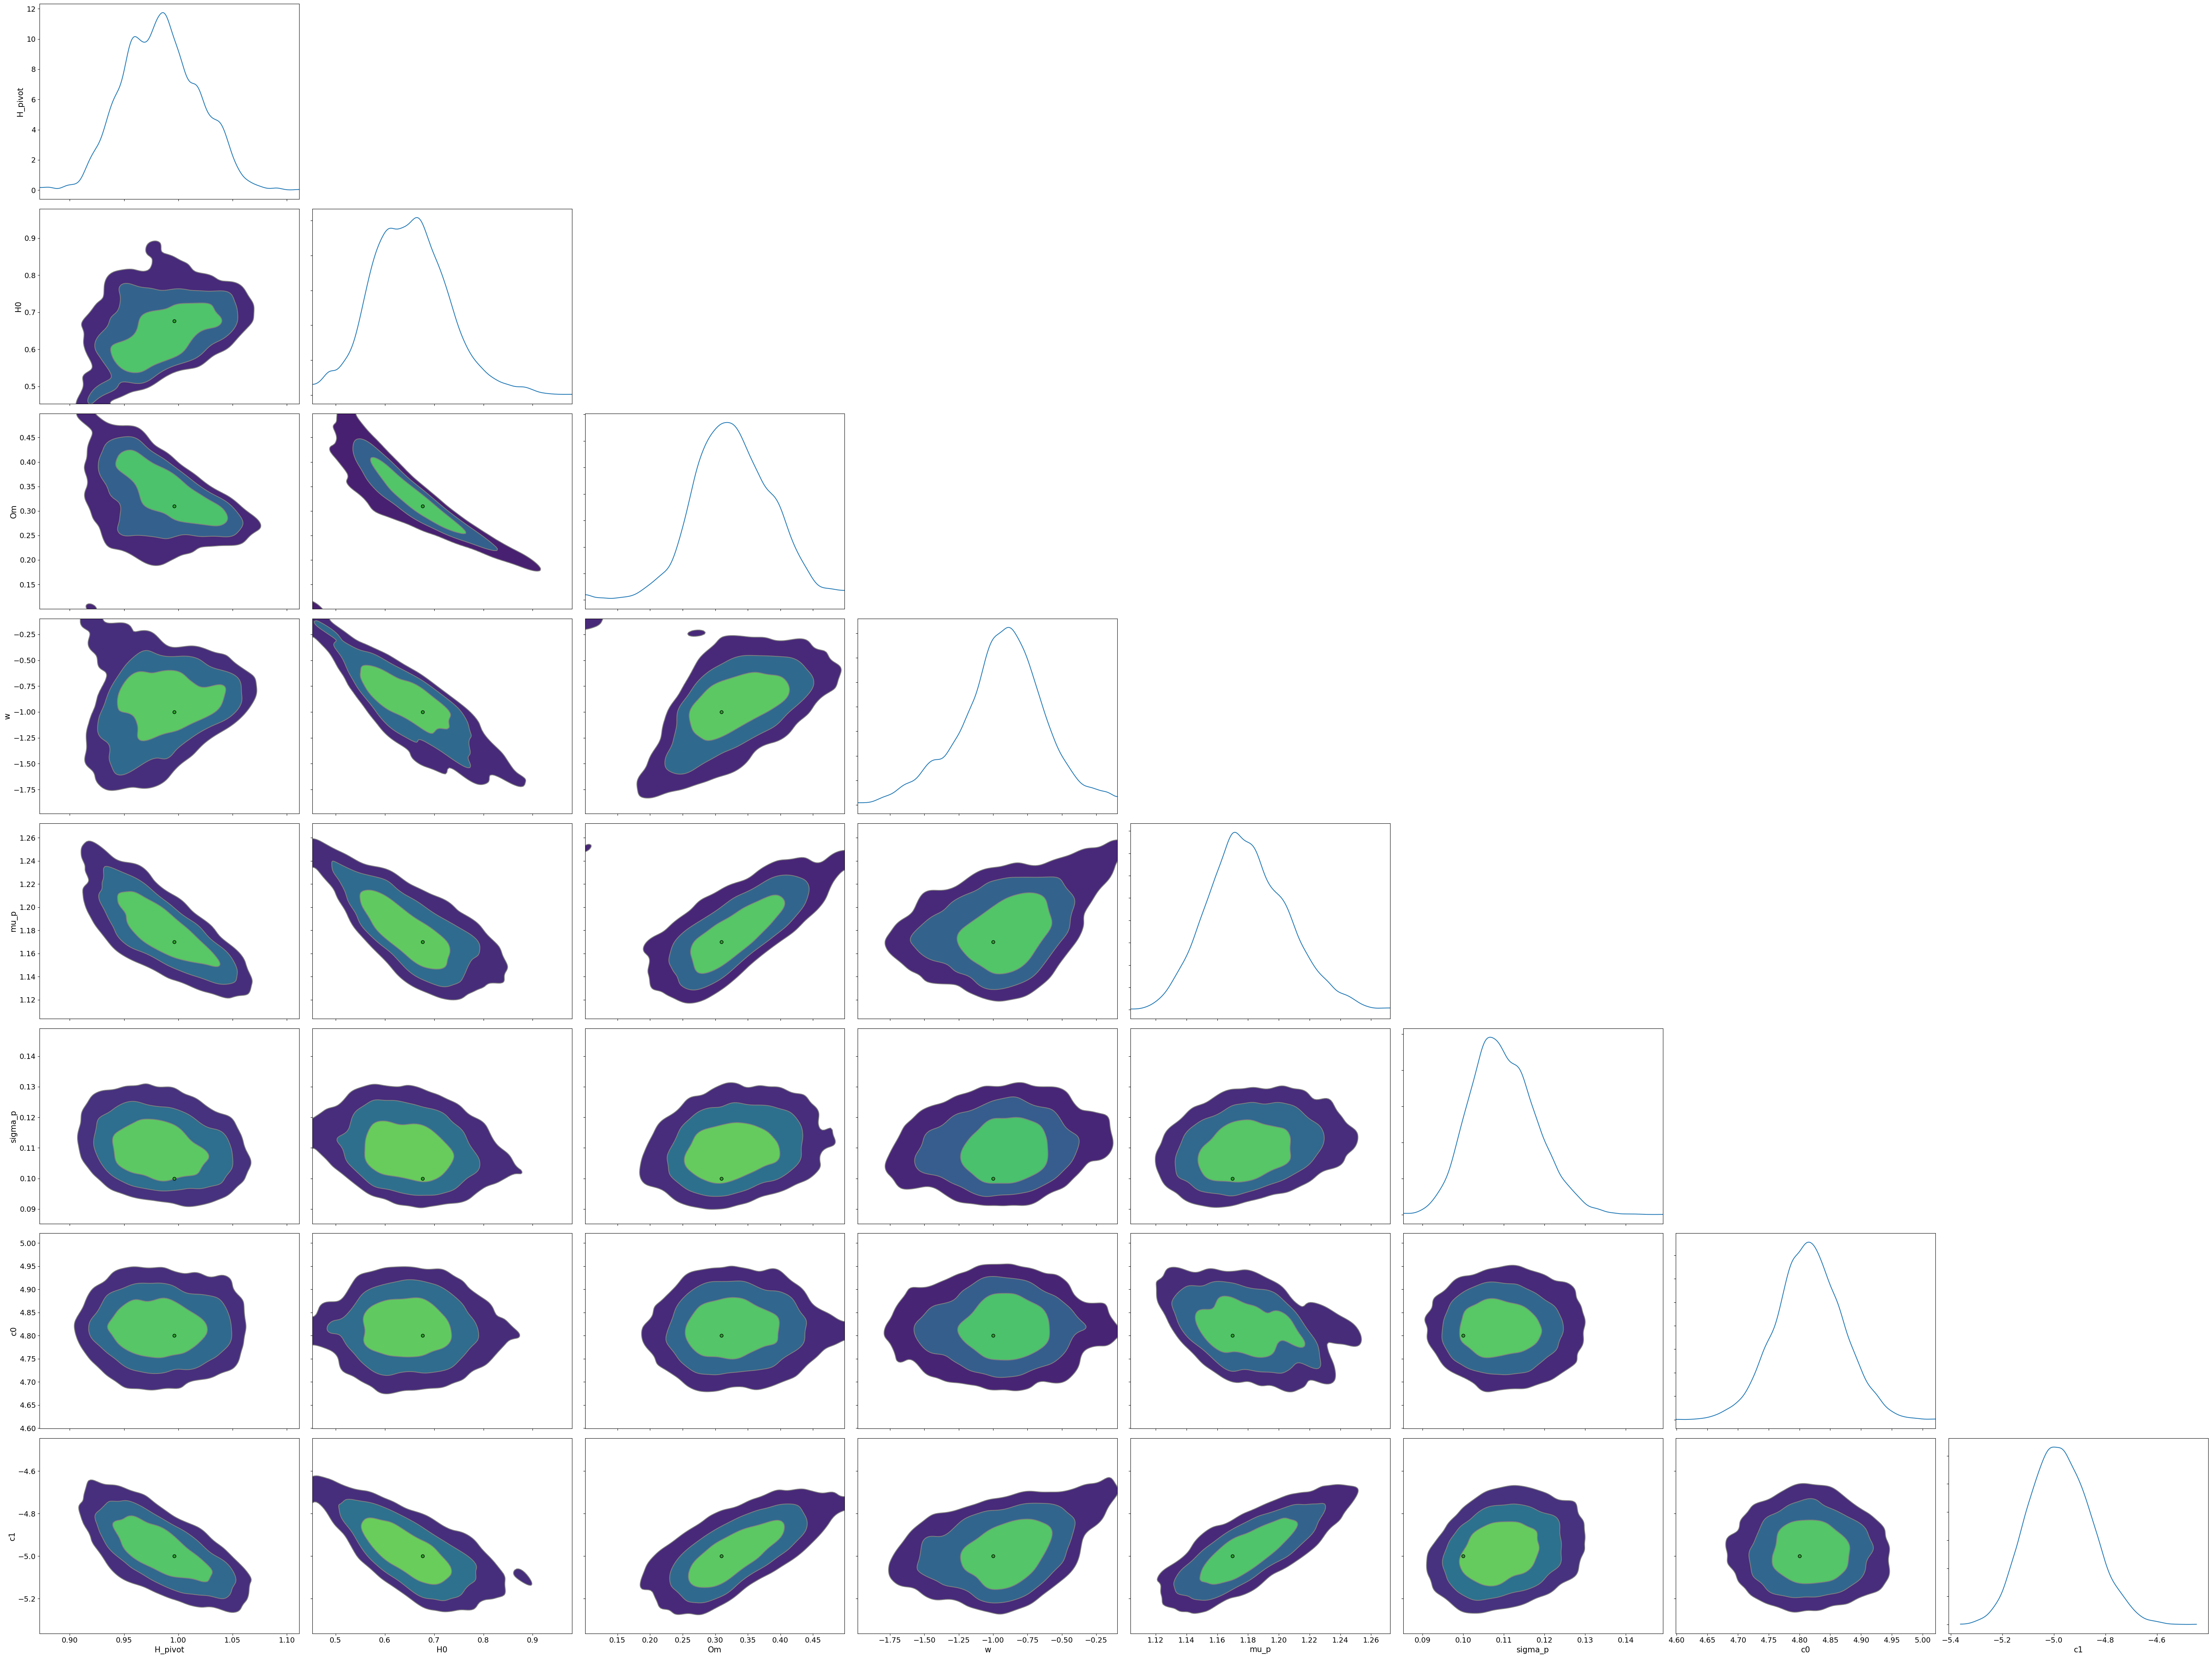

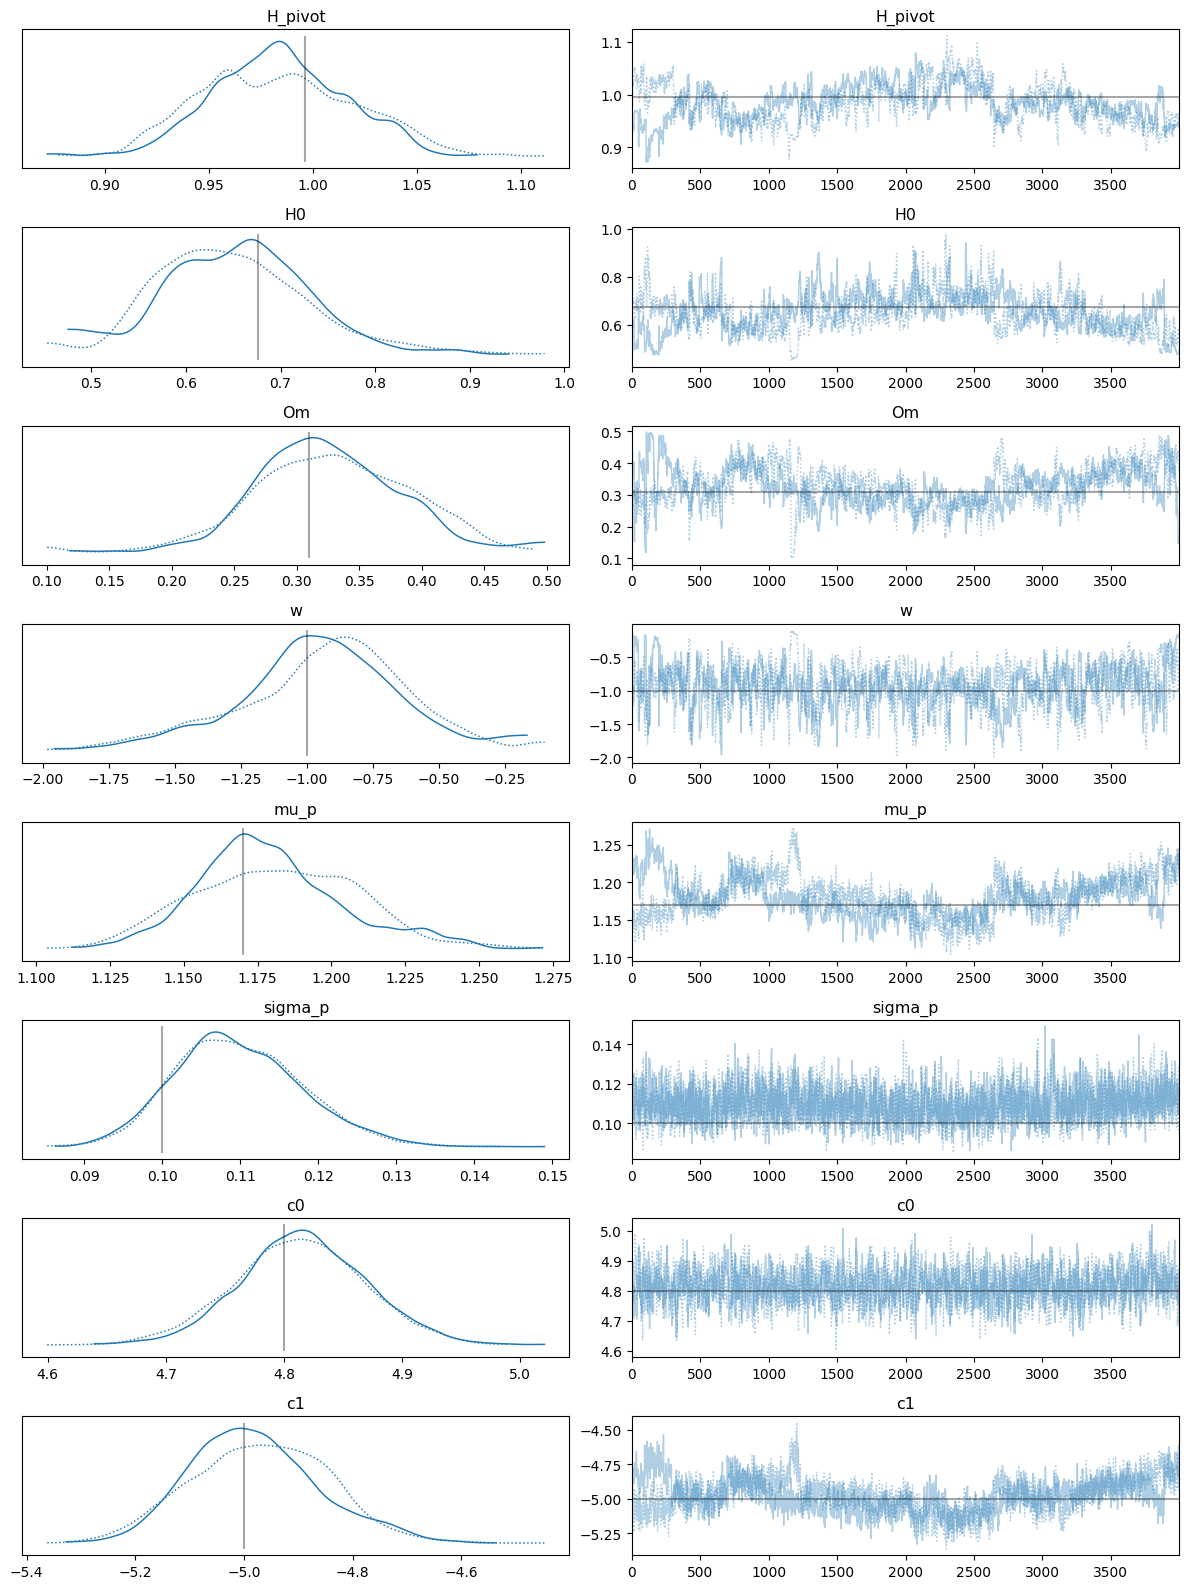

In [ ]:
import pymc as pm
import pytensor.tensor as pt
import pytensor.tensor.extra_ops as pte
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u

# --- Functions ---
def Ez(z, Om, w, wDM):
    opz = 1 + z
    return pt.sqrt(Om * opz ** (3 * (1 + wDM)) + (1 - Om) * opz ** (3 * (1 + w)))

def dCs(zs, Om, w, wDM):
    dz = zs[1:] - zs[:-1]
    fz = 1 / Ez(zs, Om, w, wDM)
    I = 0.5 * dz * (fz[:-1] + fz[1:])
    return pt.concatenate([pt.as_tensor([0.0]), pt.cumsum(I)])

def dLs(zs, dCs):
    return dCs * (1 + zs)

def pt_interp(x, xs, ys):
    x = pt.as_tensor(x)
    xs = pt.as_tensor(xs)
    ys = pt.as_tensor(ys)
    ind = pte.searchsorted(xs, x)
    ind = pt.clip(ind, 1, xs.shape[0] - 1)
    r = (x - xs[ind - 1]) / (xs[ind] - xs[ind - 1])
    return r * ys[ind] + (1 - r) * ys[ind - 1]

# --- Pivot optimization helper ---
def fracHz(z, Om=0.3, w=-1.0):
    """Proxy for fractional uncertainty σH/H from log-derivatives wrt parameters."""
    opz = 1 + z
    denom = Om + (1 - Om) * opz ** (3*w)
    num_Om = 1 - opz ** (3*w)
    num_w  = (1 - Om) * 3 * opz ** (3*w) * np.log(opz)
    return np.sqrt(num_Om**2 + num_w**2) / (2 * denom)

# --- Mock data ---
Nobs = 100
z_true = np.random.beta(3, 9, Nobs) * 10
DL_true = cosmo.luminosity_distance(z_true).to(u.Gpc).value
sigma_DL = 0.07
DL_obs = np.random.normal(DL_true, sigma_DL)

mu_p_true = 1.17
sigma_p_true = 0.1
M_source_true = np.random.normal(mu_p_true, sigma_p_true, size=Nobs)
Mz_true = (1 + z_true) * M_source_true

c0_true = 4.8
c1_true = -5.0
Lambda_true = c0_true + c1_true * ((M_source_true - mu_p_true) / 1.0)
sigma_lambda = 0.07
Lambda_obs = np.random.normal(Lambda_true, sigma_lambda)
Mz_obs = Mz_true

zinterp = np.linspace(0, 10, 1000)

# --- Choose pivot redshift (mathematically optimal) ---
z_grid = z_true #np.linspace(0.01, 10, 2000)
frac_vals = fracHz(z_grid)
z_pivot = float(z_grid[np.argmin(frac_vals)])
print("Using optimal z_pivot =", z_pivot)

# --- Model ---
with pm.Model() as model:

    # --- Cosmology priors with pivot parameterization ---
    H_pivot = pm.Uniform("H_pivot", 0.01, 3.0)  # corresponds to 30–200 km/s/Mpc
    Om = pm.Uniform("Om", 0.1, 0.5)
    w = pm.Uniform("w", -2.0, -0.01)
    wDM = 0.0

    # H0 defined from pivot: H(z_pivot) = H0 * Ez(z_pivot)
    z_piv_t = pt.as_tensor(z_pivot)
    H0 = pm.Deterministic("H0", H_pivot / Ez(z_piv_t, Om, w, wDM))

    dH = pm.Deterministic("dH", 2.99792 / H0)  # Gpc

    # --- Mass distribution ---
    mu_p = pm.Uniform("mu_p", 0.5, 2.0)
    sigma_p = pm.Uniform("sigma_p", 0.0, 0.5)

    # --- Lambda relation ---
    c0 = pm.Uniform("c0", 3.0, 6.0)
    c1 = pm.Uniform("c1", -7.0, -3.0)

    # Latent redshifts
    z_unit = pm.Beta("z_unit", 3, 9, shape=Nobs)
    z = pm.Deterministic("z", z_unit * 10)

    # Distances
    dCinterp = dH * dCs(zinterp, Om, w, wDM)
    dLinterp = dLs(zinterp, dCinterp)
    dL = pm.Deterministic("dL", pt_interp(z, zinterp, dLinterp))

    # Masses in source frame
    Mc = pm.Deterministic("Mc", Mz_obs / (1 + z))

    # Reparameterized Lambda_til
    Lambda_til = c0 + c1 * (Mc - mu_p)

    # Likelihoods
    pm.Potential("mcprior", pt.sum(pm.logp(pm.Normal.dist(mu_p, sigma_p), Mc)))
    pm.Potential("mcjac", pt.sum(-pt.log1p(z)))
    pm.Normal("dL_likelihood", mu=dL, sigma=sigma_DL, observed=DL_obs)
    pm.Normal("Lambda_til_likelihood", mu=Lambda_til, sigma=sigma_lambda, observed=Lambda_obs)

    # Initial values
    initvals = {
        "H_pivot": cosmo.H(z_pivot).value / 100,  # scale like H0/100
        "Om": cosmo.Om0,
        "w": -1.0,
        "mu_p": 1.17,
        "sigma_p": 0.1,
        "c0": 4.8,
        "c1": -5.0,
    }

    # Sampling
    trace = pm.sample(4000, tune=2000, target_accept=0.95, initvals=initvals, max_treedepth=15)

# --- Plotting ---
true_vals = {
    "H_pivot": cosmo.H(z_pivot).value / 100,
    "H0": cosmo.H0.value / 100,
    "Om": cosmo.Om0,
    "w": -1.0,
    "mu_p": 1.17,
    "sigma_p": 0.1,
    "c0": 4.8,
    "c1": -5.0,
}

summary = az.summary(trace, var_names=["H_pivot", "H0", "Om", "w", "mu_p", "sigma_p", "c0", "c1"])
print(summary)

# Pairplot
az.plot_pair(
    trace,
    var_names=["H_pivot", "H0", "Om", "w", "mu_p", "sigma_p", "c0", "c1"],
    kind="kde",
    marginals=True,
    reference_values=true_vals,
)
plt.tight_layout()
plt.show()

# Traces
az.plot_trace(trace, var_names=["H_pivot", "H0", "Om", "w", "mu_p", "sigma_p", "c0", "c1"],
              lines=[('H_pivot', {}, cosmo.H(z_pivot).value/100),
                     ('H0', {}, cosmo.H0.value/100),
                     ('Om', {}, cosmo.Om0),
                     ('w', {}, -1),
                     ('mu_p', {}, 1.17),
                     ('sigma_p', {}, 0.1),
                     ('c0', {}, 4.8),
                     ('c1', {}, -5.0)])
plt.tight_layout()
plt.show()


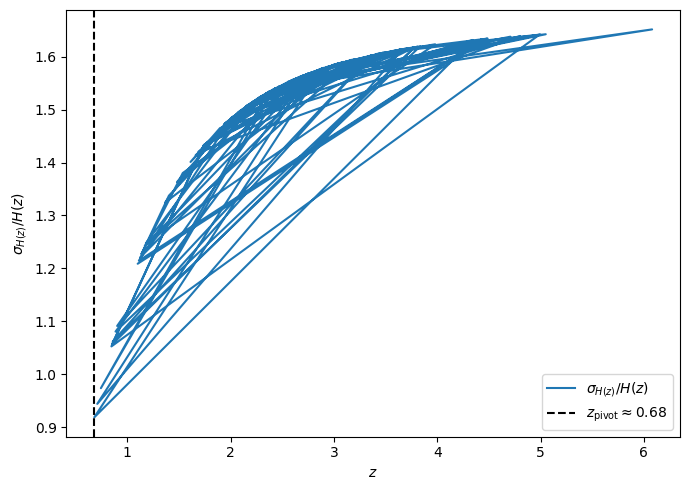

In [ ]:
# --- Diagnostic plot for pivot ---
plt.figure(figsize=(7,5))
plt.plot(z_grid, frac_vals, label=r'$\sigma_{H(z)}/H(z)$')
plt.axvline(z_pivot, color='k', ls='--', label=fr'$z_\mathrm{{pivot}} \approx {z_pivot:.2f}$')
plt.xlabel(r"$z$")
plt.ylabel(r"$\sigma_{H(z)}/H(z)$")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Save the trace to the Colab environment
az.to_netcdf(trace, "Nobs100_1309_inference_data_Hz_4k2k_95ta.nc")
print("Trace saved to Colab session storage: Nobs100_1309_inference_data_Hz_4k2k_95ta.nc")

Trace saved to Colab session storage: Nobs100_1309_inference_data_Hz_4k2k_95ta.nc


In [ ]:
from google.colab import files

files.download("Nobs100_1309_inference_data_Hz_4k2k_95ta.nc")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


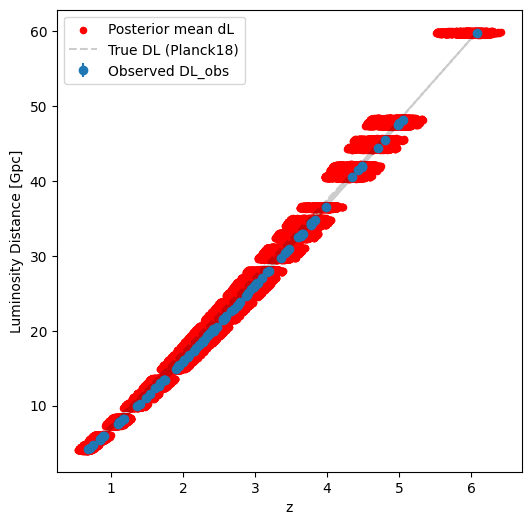

In [ ]:
import matplotlib.pyplot as plt

# take posterior mean of dL for comparison
dL_mean = trace.posterior["dL"].values
z_mean = trace.posterior["z"].values

plt.figure(figsize=(6,6))
plt.errorbar(z_true, DL_obs, yerr=0.07, fmt='o', label="Observed DL_obs")
plt.scatter(z_mean, dL_mean, color="r", label="Posterior mean dL", s=20)
plt.plot(z_true, DL_true, "k--", label="True DL (Planck18)", alpha=0.2)
plt.xlabel("z")
plt.ylabel("Luminosity Distance [Gpc]")
plt.legend()
plt.show()


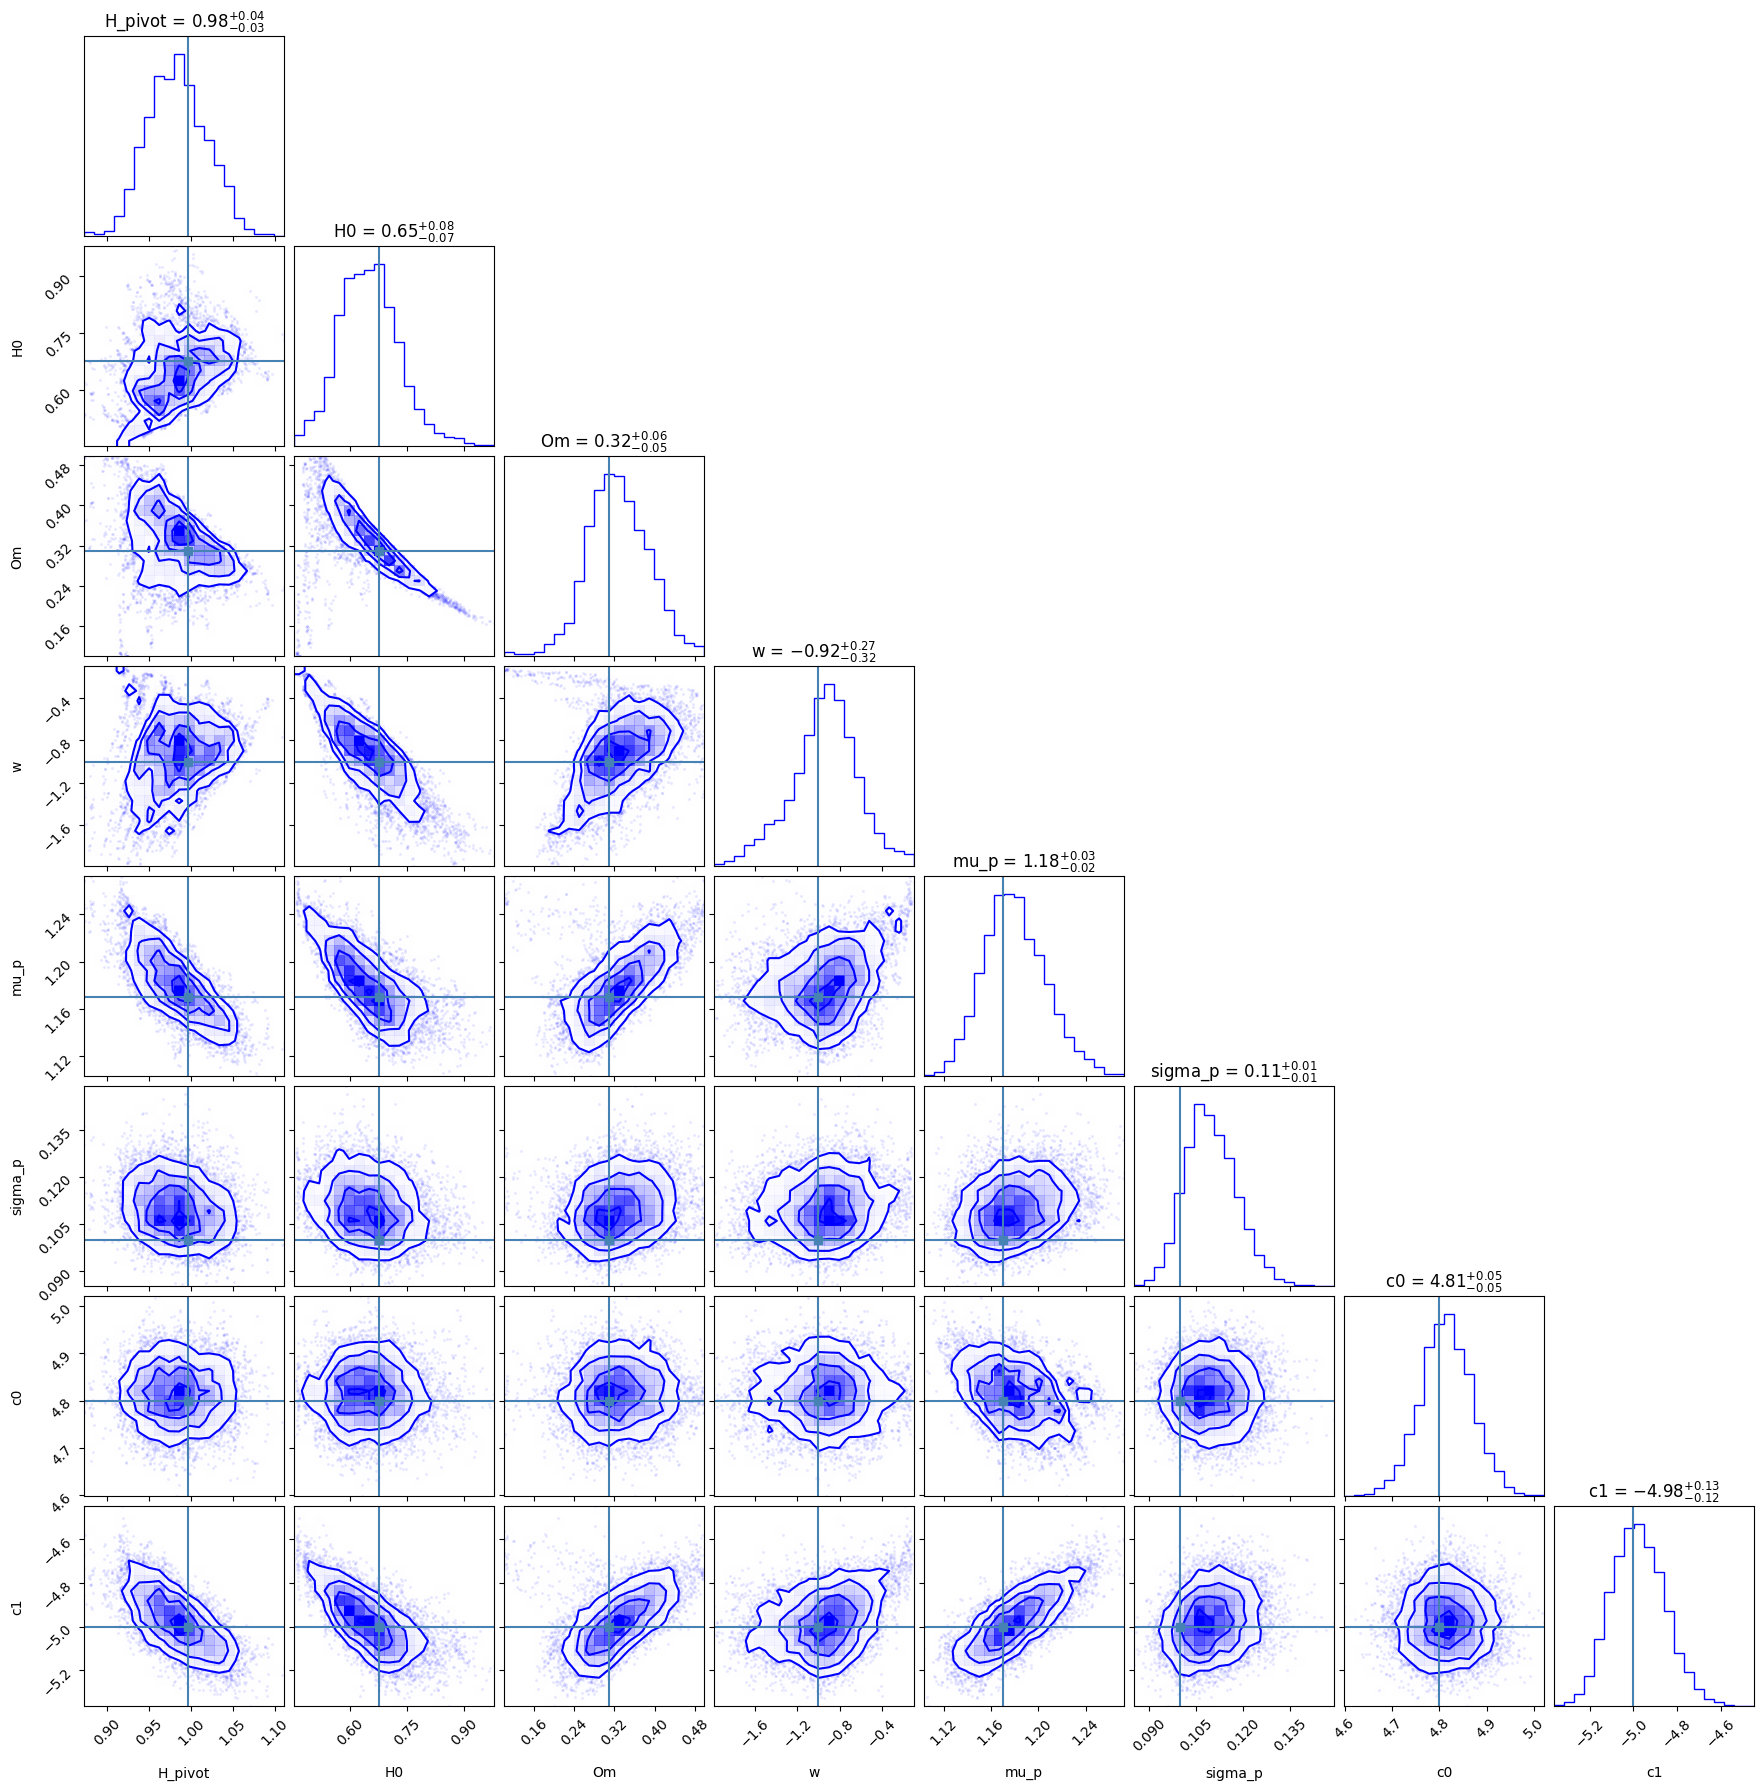

In [ ]:
import corner

# Extract the relevant parameters from the traces
trace_data = trace.posterior.stack(samples=("chain", "draw"))[["H_pivot","H0", "Om", "w", "mu_p", "sigma_p", "c0", "c1"]].to_array().values.T

# Define the labels and true values for the parameters
labels = ["H_pivot","H0", "Om", "w", "mu_p", "sigma_p", "c0", "c1"]
true_values = [cosmo.H(z_pivot).value/100,cosmo.H0.value/100, cosmo.Om0, -1.0, 1.17, 0.1, 4.8, -5.0]

# Create the corner plot
figure = corner.corner(trace_data, labels=labels, show_titles=True, color="blue", hist_kwargs={"density": True}, truths=true_values)

plt.show()

###Next Step

Introducing, mass ratio $(q) = \frac{m_2}{m_1}$

Such that: $0 < q < 1$

New Formulae we might need:

$$
M_c = \frac{(m_1 m_2)^{3/5}}{(m_1+m_2)^{1/5}} \quad
$$

Assuming we have $M_c$ and $q$, we can find:
$$
m_1 = M_c \cdot \frac{(1+q)^{1/5}}{q^{3/5}}, \quad
m_2 = M_c \cdot (1+q)^{1/5} \cdot q^{2/5}
$$

Now, for the two binaries, EOS formulae:

$$
\Lambda_1 = c_0 + c_1 (m_1 - \mu_p), \quad
\Lambda_2 = c_0 + c_1 (m_2 - \mu_p)
$$

$$
\therefore \tilde{\Lambda} = \frac{16}{13} \cdot \frac{(m_1+12m_2)m_1^4 \Lambda_1 + (m_2+12m_1)m_2^4 \Lambda_2}{(m_1+m_2)^5}
$$